In [1]:
import os

os.chdir("../..")
os.getcwd()

'/home/mario/PhD/spatial_lda'

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import subprocess
import pymc3 as pm
import seaborn as sns

from spatial_mix.utils import *
from spatial_mix.protos.py.univariate_mixture_state_pb2 import UnivariateState, UnivariateMixtureState, HdpState

current_palette = sns.color_palette()

In [15]:
covariates = ["host_is_superhost", "accommodates", "bathrooms", "bedrooms", "number_of_reviews", "review_scores_rating", "instant_bookable"]

# Run

In [31]:
with open("data/amsterdam.pkl", "rb") as fp:
    datas = pickle.load(fp)

In [32]:
datas.keys()

dict_keys(['y', 'G', 'neigh_names', 'cov'])

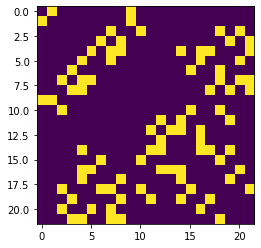

In [33]:
plt.imshow(datas["G"])

In [36]:
covariates_by_group = []
for i, cov in enumerate(datas["cov"]):      
    curr = cov[covariates]
    if(curr.isna().sum().sum()):
        print("Nans in group {0}".format(i))
        
    curr.loc[:, "host_is_superhost"] = (curr["host_is_superhost"]=="t").astype(int).values
    curr.loc[:, "instant_bookable"] = (curr["instant_bookable"]=="t").astype(int).values
    curr = np.hstack([np.ones(len(curr)).reshape(-1, 1), curr.values])
    covariates_by_group.append(curr)

In [37]:
for i in range(len(datas["y"])):
    if len(datas["y"][i]) != len(datas["cov"][i]):
        print("error in ", i)
        print("datas: ", len(datas["y"][i]), " covariates", covariates_by_group[i].shape[0])

In [38]:
chains = runSpatialMixtureSampler(
    10000, 10000, 5, datas["G"], 
    "spatial_mix/resources/sampler_params.asciipb",
    datas["y"], covariates_by_group)

Burn-in, iter # 200  /  10000
Burn-in, iter # 400  /  10000
Burn-in, iter # 600  /  10000
Burn-in, iter # 800  /  10000
Burn-in, iter # 1000  /  10000
Burn-in, iter # 1200  /  10000
Burn-in, iter # 1400  /  10000
Burn-in, iter # 1600  /  10000
Burn-in, iter # 1800  /  10000
Burn-in, iter # 2000  /  10000
Burn-in, iter # 2200  /  10000
Burn-in, iter # 2400  /  10000
Burn-in, iter # 2600  /  10000
Burn-in, iter # 2800  /  10000
Burn-in, iter # 3000  /  10000
Burn-in, iter # 3200  /  10000
Burn-in, iter # 3400  /  10000
Burn-in, iter # 3600  /  10000
Burn-in, iter # 3800  /  10000
Burn-in, iter # 4000  /  10000
Burn-in, iter # 4200  /  10000
Burn-in, iter # 4400  /  10000
Burn-in, iter # 4600  /  10000
Burn-in, iter # 4800  /  10000
Burn-in, iter # 5000  /  10000
Burn-in, iter # 5200  /  10000
Burn-in, iter # 5400  /  10000
Burn-in, iter # 5600  /  10000
Burn-in, iter # 5800  /  10000
Burn-in, iter # 6000  /  10000
Burn-in, iter # 6200  /  10000
Burn-in, iter # 6400  /  10000
Burn-in, ite

In [39]:
writeChains(chains, "data/amsterdam_serialized_chains_with_intercept_05032020.recordio")

# Posterior Plots

In [40]:
import arviz as az

In [41]:
chains = loadChains("data/amsterdam_serialized_chains_with_intercept_05032020.recordio")

## Regression Coefficients

In [51]:
p_size = len(chains[0].regression_coefficients)
regressor_chains = {}
covariates = ["intercept"] + covariates
for i, name in enumerate(covariates):
    regressor_chains[name] = np.array([c.regression_coefficients[i] for c in chains])

TypeError: unhashable type: 'list'

In [43]:
azChains = az.convert_to_inference_data(regressor_chains)

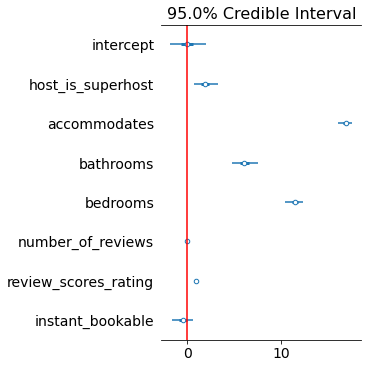

In [50]:
axes = az.plot_forest(azChains, credible_interval=0.95, figsize=(5, 5))
axes[0].axvline(color="red")
plt.savefig("images/regression_coefficients.pdf")
plt.show()

## Couple of residual densities

In [69]:
xgrid = np.linspace(-200, 200, 1000)
dens = estimateDensities(chains, xgrids=xgrid)

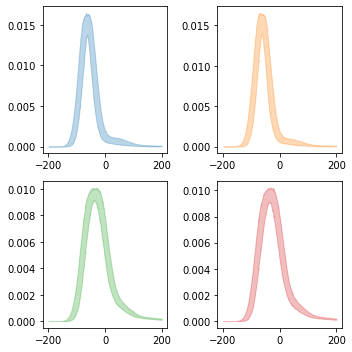

In [73]:
fig, axes = plt.subplots(nrows=2 , ncols=2, figsize=(5, 5))
toplot = [0, 9, 14, 19]
axes = axes.flat


for i in range(4):
    g = toplot[i]
    intervals = np.array([pm.stats.hpd(dens[g][:, i], 0.05) for i in range(dens[g].shape[1])])  
    axes[i].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.3, color=current_palette[i])

plt.tight_layout()
plt.savefig("images/dens_estimates_res_amsterdam.pdf")
plt.show()